Using 1 GPUs
Features to preprocess: 460
X_train shape: (9362, 10, 46)
y_train shape: (9362, 1)
X_val shape: (2341, 10, 46)
y_val shape: (2341, 1)

Epoch [1/100], Train Loss: 1.2064, Train Acc: 39.80%, Val Loss: 1.1354, Val Acc: 43.10%, Avg Grad Norm: 1.0000
Epoch [2/100], Train Loss: 1.1882, Train Acc: 38.99%, Val Loss: 1.1147, Val Acc: 43.40%, Avg Grad Norm: 1.0000
Epoch [3/100], Train Loss: 1.1638, Train Acc: 39.97%, Val Loss: 1.0994, Val Acc: 43.96%, Avg Grad Norm: 1.0000
Epoch [4/100], Train Loss: 1.1567, Train Acc: 39.53%, Val Loss: 1.0870, Val Acc: 44.77%, Avg Grad Norm: 1.0000
Epoch [5/100], Train Loss: 1.1430, Train Acc: 40.24%, Val Loss: 1.0769, Val Acc: 44.98%, Avg Grad Norm: 1.0000
Epoch [6/100], Train Loss: 1.1327, Train Acc: 40.58%, Val Loss: 1.0678, Val Acc: 45.75%, Avg Grad Norm: 1.0000
Epoch [7/100], Train Loss: 1.1263, Train Acc: 41.12%, Val Loss: 1.0600, Val Acc: 46.35%, Avg Grad Norm: 1.0000
Epoch [8/100], Train Loss: 1.1097, Train Acc: 42.11%, Val Loss: 1.0534, Val

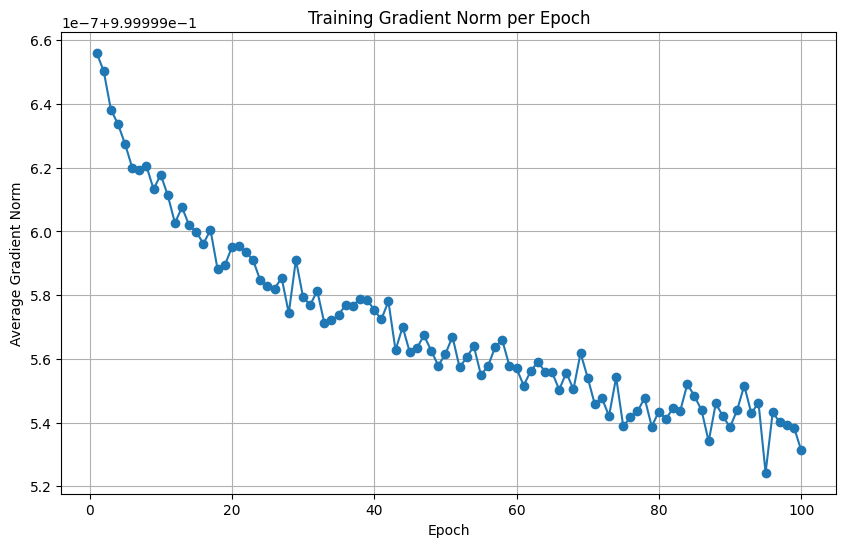

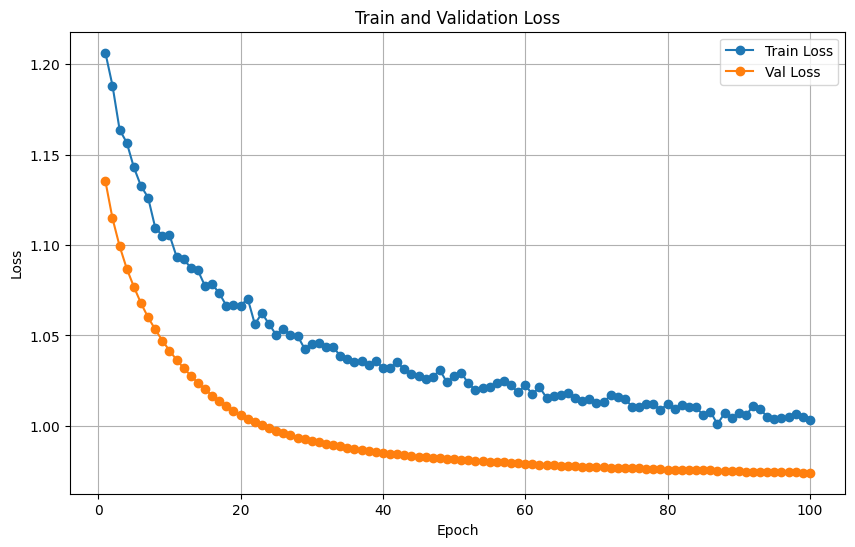

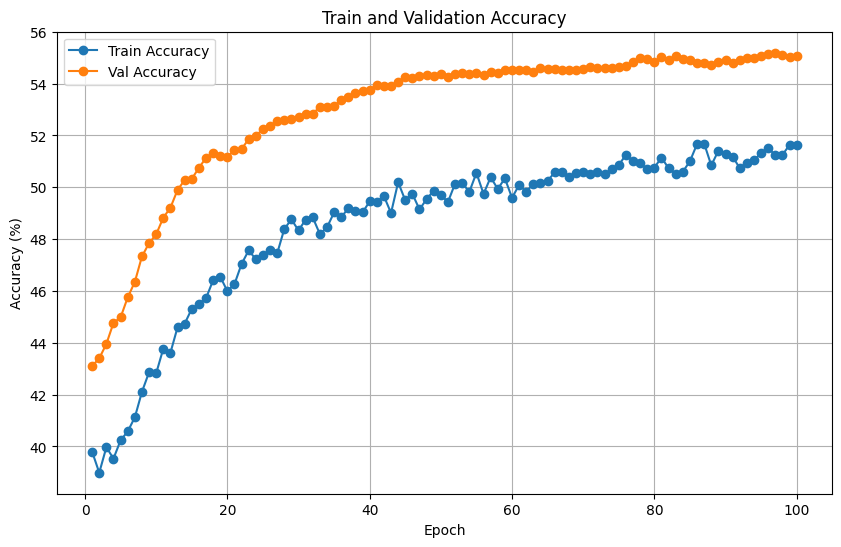

Validation F1 Score: 0.4736
Odds for gameID 15463 are missing (NaN). Skipping this game.

Betting Simulation Results:
Total Bets Placed: 2340
Wins: 1288, Losses: 1052
Final Capital: £1358.45
Home: 1611
Draw: 18
Correct draw: 7
Away: 712
Underdogs predicted: 317
Underdogs predicted correctly: 113


In [4]:
# GRU IMPLEMENTATION
# GRU IMPLEMENTATION
# GRU IMPLEMENTATION

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score  # Import F1 score evaluation
import matplotlib.pyplot as plt
import torch.nn.functional as F

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Check GPU availability and enable multi-GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")

# Set configuration
class CFG:
    seed = 142
    classes = 3
    use_class_weights = False
    batch_size = 200
    epochs = 100
    early_stopping_patience = 5
    timesteps = 10
    target = 'result'
    
    # Define historical features
    historical_features = [
        # Home based
        'h_is_home', 'h_goals', 'h_goals_faced', 'h_xGoals', 'h_xGoals_faced',
        'h_shots', 'h_shots_faced', 'h_shotsOnTarget', 'h_shotsOnTarget_faced',
        'h_deep', 'h_deep_faced', 'h_ppda', 'h_ppda_faced', 'h_fouls',
        'h_fouls_faced', 'h_corners', 'h_corners_faced', 'h_yellowCards',
        'h_yellowCards_faced', 'h_redCards', 'h_redCards_faced', 'h_result',
        'h_days_since_match',
        
        # Away based
        'a_is_home', 'a_goals', 'a_goals_faced', 'a_xGoals', 'a_xGoals_faced',
        'a_shots', 'a_shots_faced', 'a_shotsOnTarget', 'a_shotsOnTarget_faced',
        'a_deep', 'a_deep_faced', 'a_ppda', 'a_ppda_faced', 'a_fouls',
        'a_fouls_faced', 'a_corners', 'a_corners_faced', 'a_yellowCards',
        'a_yellowCards_faced', 'a_redCards', 'a_redCards_faced', 'a_result',
        'a_days_since_match'
    ] 

# Set seed for reproducibility
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CFG.seed)

# Helper function: Convert wide format to long format for time series modeling
def wide_to_long(df, feature: str, timesteps: int):
    df_ = df.copy()
    if feature not in CFG.historical_features:
        features = [feature]
    else:
        features = [f'{feature}_{i}' for i in range(timesteps)][::-1]
    df_ = df_[['gameID'] + features]
    series = df_.set_index('gameID').stack().reset_index(level=1)[0].rename(feature)
    return series

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------

# Load processed data for training/validation
train_file_path = "mlpdata/processed_cleandata.csv"
df = pd.read_csv(train_file_path)

# Encode target labels: '1'->0, 'X'->1, '2'->2
target2int = {'1': 0, 'X': 1, '2': 2}
df['result'] = df['result'].map(target2int)

# Split data into train (80%) and validation (20%)
X_train, X_val = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

# Identify historical features to preprocess (using regex to match timestep suffix)
features_pattern = '_[0-9]|'.join(CFG.historical_features) + '_[0-9]'
features_to_preprocess = df.filter(regex=features_pattern, axis=1).columns.tolist()
print('Features to preprocess:', len(features_to_preprocess))

# Apply StandardScaler normalization
scaler = StandardScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train[features_to_preprocess]), columns=features_to_preprocess)
X_train = pd.concat([X_train[['gameID', 'result']], X_train_pre], axis=1)
X_val_pre = pd.DataFrame(scaler.transform(X_val[features_to_preprocess]), columns=features_to_preprocess)
X_val = pd.concat([X_val[['gameID', 'result']], X_val_pre], axis=1)

# Create DataFrame versions for time series conversion.
X_train_df = pd.DataFrame(X_train, columns=['gameID', 'result'] + features_to_preprocess)
X_val_df = pd.DataFrame(X_val, columns=['gameID', 'result'] + features_to_preprocess)

# Save validation gameIDs for later betting simulation.
val_gameIDs = X_val_df['gameID'].tolist()

# Create target variables (time-series format)
y_train = wide_to_long(X_train_df, 'result', timesteps=CFG.timesteps).values.reshape(-1, 1)
y_val = wide_to_long(X_val_df, 'result', timesteps=CFG.timesteps).values.reshape(-1, 1)

# Convert historical features into time-series format.
X_train_series = pd.concat([
    wide_to_long(X_train_df, feature=feature, timesteps=CFG.timesteps) 
    for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_val_series = pd.concat([
    wide_to_long(X_val_df, feature=feature, timesteps=CFG.timesteps) 
    for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))

print("X_train shape:", X_train_series.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val_series.shape)
print("y_val shape:", y_val.shape)
print()

# -------------------------------
# Model Definition (GRU version)
# -------------------------------
class FootballGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, timesteps, num_classes):
        super(FootballGRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.layernorm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(timesteps * hidden_dim, num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.layernorm(x)
        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# -------------------------------
# DataLoader Creation
# -------------------------------
train_dataset = TensorDataset(
    torch.tensor(X_train_series, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_series, dtype=torch.float32), 
    torch.tensor(y_val, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -------------------------------
# Model, Loss, and Optimizer
# -------------------------------
model = FootballGRUModel(
    input_dim=X_train_series.shape[2],
    hidden_dim=16,
    num_layers=2,
    timesteps=X_train_series.shape[1],
    num_classes=CFG.classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)

# -------------------------------
# Training Loop with Early Stopping
# -------------------------------
best_val_loss = float('inf')
patience_counter = 0

def evaluate(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels.squeeze()).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return avg_val_loss, val_accuracy

train_losses, val_losses = [], []
train_accs, val_accs = [], []
grad_norms = []

for epoch in range(CFG.epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_grad_norms = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Record gradient norm
        batch_grad_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                batch_grad_norm += param.grad.data.norm(2).item() ** 2
        batch_grad_norm = batch_grad_norm ** 0.5
        epoch_grad_norms.append(batch_grad_norm)
        
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.squeeze()).sum().item()
        total += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    avg_grad_norm = np.mean(epoch_grad_norms)
    
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    train_losses.append(avg_loss)
    val_losses.append(val_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    grad_norms.append(avg_grad_norm)
    
    print(f"Epoch [{epoch+1}/{CFG.epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
          f"Avg Grad Norm: {avg_grad_norm:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= CFG.early_stopping_patience:
            print("Early stopping triggered")
            break

# Plot training stats
plt.figure(figsize=(10,6))
plt.plot(range(1, len(grad_norms)+1), grad_norms, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Training Gradient Norm per Epoch')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Betting Simulation and F1 Score Evaluation on Validation Set
# -------------------------------

# Load games.csv which contains betting odds for each game.
games_df = pd.read_csv("mlpdata/games.csv")

# Set the model to the best saved state and switch to evaluation mode.
model.load_state_dict(best_model_state)
model.eval()

# Obtain predictions on the full validation set.
all_preds = []
all_truths = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_truths.extend(labels.squeeze().cpu().numpy().tolist())

# Compute F1 Score
f1 = f1_score(all_truths, all_preds, average='weighted')
print(f"Validation F1 Score: {f1:.4f}")

# Make sure the number of predictions matches the number of validation gameIDs.
if len(all_preds) != len(val_gameIDs):
    print("Warning: Number of predictions does not match number of validation gameIDs.")

# Initialize betting simulation variables.
capital = 0.0
wins = 0
losses = 0
bets_placed = 0  # Count only bets where odds are valid
home = 0
draw = 0
away = 0
underdogs_predicted = 0
underdogs_correct = 0
correct_draw = 0

# Loop over each game in the validation set.
for game_id, pred, truth in zip(val_gameIDs, all_preds, all_truths):
    # Retrieve the row from games.csv for this game_id.
    underdog = False
    odds_row = games_df[games_df['gameID'] == game_id]
    if odds_row.empty:
        print(f"GameID {game_id} not found in games.csv. Skipping this game.")
        continue
    
    # Get the odds based on the model prediction:
    #   0 corresponds to home win -> use B365H
    #   1 corresponds to draw    -> use B365D
    #   2 corresponds to away win -> use B365A
    if pred == 0:
        odds = odds_row.iloc[0]['B365H']
        home += 1
        if odds_row.iloc[0]['B365H'] > odds_row.iloc[0]['B365A']:
            underdog = True
            underdogs_predicted += 1
    elif pred == 1:
        odds = odds_row.iloc[0]['B365D']
        draw += 1
    elif pred == 2:
        odds = odds_row.iloc[0]['B365A']
        away += 1
        if odds_row.iloc[0]['B365H'] < odds_row.iloc[0]['B365A']:
            underdog = True
            underdogs_predicted += 1
    else:
        print(f"Unexpected prediction {pred} for gameID {game_id}. Skipping.")
        continue

    if pd.isna(odds):
        print(f"Odds for gameID {game_id} are missing (NaN). Skipping this game.")
        continue

    bets_placed += 1
    if pred == truth:
        capital += odds
        wins += 1
        if underdog:
            underdogs_correct += 1
        elif pred == 1:
            correct_draw += 1
    else:
        capital -= 1
        losses += 1

print("\nBetting Simulation Results:")
print(f"Total Bets Placed: {bets_placed}")
print(f"Wins: {wins}, Losses: {losses}")
print(f"Final Capital: £{capital:.2f}")
print(f"Home: {home}")
print(f"Draw: {draw}")
print(f"Correct draw: {correct_draw}")
print(f"Away: {away}")
print(f"Underdogs predicted: {underdogs_predicted}")
print(f"Underdogs predicted correctly: {underdogs_correct}")



Using 1 GPUs
Features to preprocess: 460
X_train shape: (9362, 10, 46)
y_train shape: (9362, 1)
X_val shape: (2341, 10, 46)
y_val shape: (2341, 1)

Epoch [1/100], Train Loss: 1.1609, Train Acc: 37.59%, Val Loss: 1.0773, Val Acc: 44.85%, Avg Grad Norm: 1.0000
Epoch [2/100], Train Loss: 1.1458, Train Acc: 38.36%, Val Loss: 1.0738, Val Acc: 45.07%, Avg Grad Norm: 1.0000
Epoch [3/100], Train Loss: 1.1490, Train Acc: 38.06%, Val Loss: 1.0707, Val Acc: 45.41%, Avg Grad Norm: 1.0000
Epoch [4/100], Train Loss: 1.1432, Train Acc: 39.52%, Val Loss: 1.0678, Val Acc: 45.58%, Avg Grad Norm: 1.0000
Epoch [5/100], Train Loss: 1.1378, Train Acc: 40.31%, Val Loss: 1.0650, Val Acc: 45.62%, Avg Grad Norm: 1.0000
Epoch [6/100], Train Loss: 1.1309, Train Acc: 39.97%, Val Loss: 1.0623, Val Acc: 45.92%, Avg Grad Norm: 1.0000
Epoch [7/100], Train Loss: 1.1261, Train Acc: 41.04%, Val Loss: 1.0595, Val Acc: 46.13%, Avg Grad Norm: 1.0000
Epoch [8/100], Train Loss: 1.1193, Train Acc: 40.92%, Val Loss: 1.0569, Val

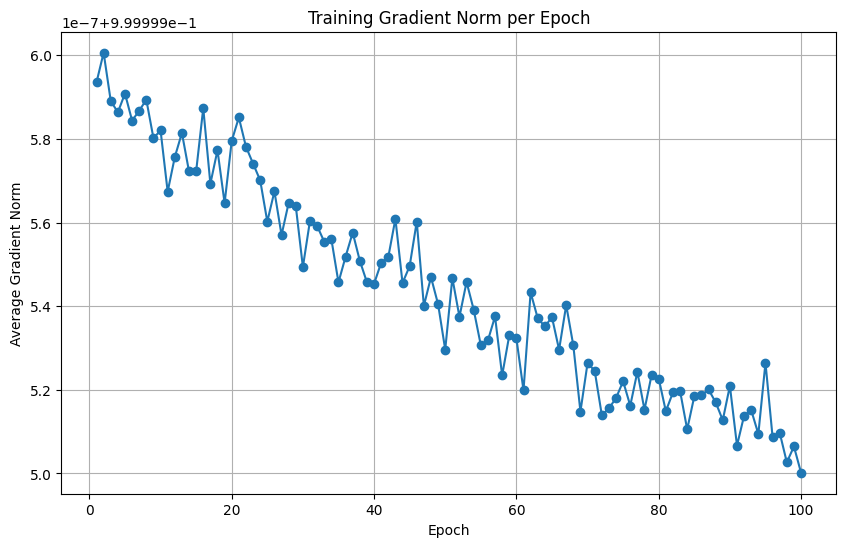

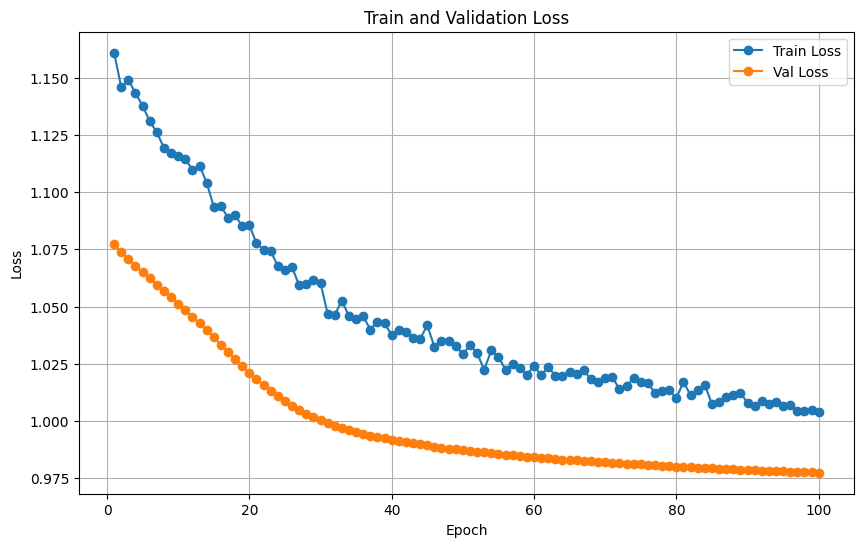

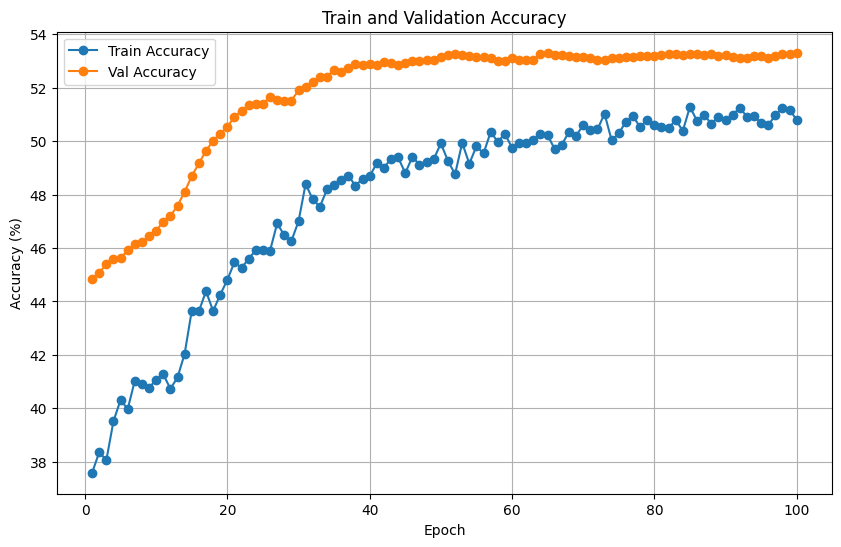

Validation F1 Score: 0.4528
Odds for gameID 15463 are missing (NaN). Skipping this game.

Betting Simulation Results:
Total Bets Placed: 2340
Wins: 1247, Losses: 1093
Final Capital: £1206.25
Home: 1646
Draw: 2
Correct draw: 2
Away: 693
Underdogs predicted: 332
Underdogs predicted correctly: 98


In [2]:
# LSTM IMPLEMENTATION
# LSTM IMPLEMENTATION
# LSTM IMPLEMENTATION

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score  # Import F1 score evaluation
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check GPU availability and enable multi-GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")

# Set configuration
class CFG:
    seed = 142
    classes = 3
    use_class_weights = False
    batch_size = 200
    epochs = 100
    early_stopping_patience = 5
    timesteps = 10
    target = 'result'
    
    # Define historical features
    historical_features = [
        # Home based
        'h_is_home', 'h_goals', 'h_goals_faced', 'h_xGoals', 'h_xGoals_faced',
        'h_shots', 'h_shots_faced', 'h_shotsOnTarget', 'h_shotsOnTarget_faced',
        'h_deep', 'h_deep_faced', 'h_ppda', 'h_ppda_faced', 'h_fouls',
        'h_fouls_faced', 'h_corners', 'h_corners_faced', 'h_yellowCards',
        'h_yellowCards_faced', 'h_redCards', 'h_redCards_faced', 'h_result',
        'h_days_since_match',
        
        # Away based
        'a_is_home', 'a_goals', 'a_goals_faced', 'a_xGoals', 'a_xGoals_faced',
        'a_shots', 'a_shots_faced', 'a_shotsOnTarget', 'a_shotsOnTarget_faced',
        'a_deep', 'a_deep_faced', 'a_ppda', 'a_ppda_faced', 'a_fouls',
        'a_fouls_faced', 'a_corners', 'a_corners_faced', 'a_yellowCards',
        'a_yellowCards_faced', 'a_redCards', 'a_redCards_faced', 'a_result',
        'a_days_since_match'
    ] 

# Set seed for reproducibility
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CFG.seed)

# Helper function: Convert wide format to long format for time series modeling
def wide_to_long(df, feature: str, timesteps: int):
    df_ = df.copy()
    if feature not in CFG.historical_features:
        features = [feature]
    else:
        features = [f'{feature}_{i}' for i in range(timesteps)][::-1]
    df_ = df_[['gameID'] + features]
    series = df_.set_index('gameID').stack().reset_index(level=1)[0].rename(feature)
    return series

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------

# Load processed data for training/validation
train_file_path = "mlpdata/processed_cleandata.csv"
df = pd.read_csv(train_file_path)

# Encode target labels: '1'->0, 'X'->1, '2'->2
target2int = {'1': 0, 'X': 1, '2': 2}
df['result'] = df['result'].map(target2int)

# Split data into train (80%) and validation (20%)
X_train, X_val = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

# Identify historical features to preprocess (using regex to match timestep suffix)
features_pattern = '_[0-9]|'.join(CFG.historical_features) + '_[0-9]'
features_to_preprocess = df.filter(regex=features_pattern, axis=1).columns.tolist()
print('Features to preprocess:', len(features_to_preprocess))

# Apply StandardScaler normalization
scaler = StandardScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train[features_to_preprocess]), columns=features_to_preprocess)
X_train = pd.concat([X_train[['gameID', 'result']], X_train_pre], axis=1)
X_val_pre = pd.DataFrame(scaler.transform(X_val[features_to_preprocess]), columns=features_to_preprocess)
X_val = pd.concat([X_val[['gameID', 'result']], X_val_pre], axis=1)

# Create DataFrame versions for time series conversion.
X_train_df = pd.DataFrame(X_train, columns=['gameID', 'result'] + features_to_preprocess)
X_val_df = pd.DataFrame(X_val, columns=['gameID', 'result'] + features_to_preprocess)

# Save validation gameIDs for later betting simulation.
val_gameIDs = X_val_df['gameID'].tolist()

# Create target variables (time-series format)
y_train = wide_to_long(X_train_df, 'result', timesteps=CFG.timesteps).values.reshape(-1, 1)
y_val = wide_to_long(X_val_df, 'result', timesteps=CFG.timesteps).values.reshape(-1, 1)

# Convert historical features into time-series format.
X_train_series = pd.concat([
    wide_to_long(X_train_df, feature=feature, timesteps=CFG.timesteps) 
    for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))
X_val_series = pd.concat([
    wide_to_long(X_val_df, feature=feature, timesteps=CFG.timesteps) 
    for feature in CFG.historical_features
], axis=1).values.reshape(-1, CFG.timesteps, len(CFG.historical_features))

print("X_train shape:", X_train_series.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val_series.shape)
print("y_val shape:", y_val.shape)
print()

# -------------------------------
# Model Definition (LSTM version)
# -------------------------------
class FootballLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, timesteps, num_classes):
        super(FootballLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.layernorm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(timesteps * hidden_dim, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.layernorm(x)
        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# -------------------------------
# DataLoader Creation
# -------------------------------
train_dataset = TensorDataset(
    torch.tensor(X_train_series, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_series, dtype=torch.float32), 
    torch.tensor(y_val, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -------------------------------
# Model, Loss, and Optimizer
# -------------------------------
model = FootballLSTMModel(
    input_dim=X_train_series.shape[2],
    hidden_dim=16,
    num_layers=2,
    timesteps=X_train_series.shape[1],
    num_classes=CFG.classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)

# -------------------------------
# Training Loop with Early Stopping
# -------------------------------
best_val_loss = float('inf')
patience_counter = 0

def evaluate(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels.squeeze()).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return avg_val_loss, val_accuracy

train_losses, val_losses = [], []
train_accs, val_accs = [], []
grad_norms = []

for epoch in range(CFG.epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_grad_norms = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Record gradient norm
        batch_grad_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                batch_grad_norm += param.grad.data.norm(2).item() ** 2
        batch_grad_norm = batch_grad_norm ** 0.5
        epoch_grad_norms.append(batch_grad_norm)
        
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.squeeze()).sum().item()
        total += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    avg_grad_norm = np.mean(epoch_grad_norms)
    
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    train_losses.append(avg_loss)
    val_losses.append(val_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    grad_norms.append(avg_grad_norm)
    
    print(f"Epoch [{epoch+1}/{CFG.epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
          f"Avg Grad Norm: {avg_grad_norm:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= CFG.early_stopping_patience:
            print("Early stopping triggered")
            break

# Plot training stats
plt.figure(figsize=(10,6))
plt.plot(range(1, len(grad_norms)+1), grad_norms, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Training Gradient Norm per Epoch')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Betting Simulation and F1 Score Evaluation on Validation Set
# -------------------------------

# Load games.csv which contains betting odds for each game.
games_df = pd.read_csv("mlpdata/games.csv")

# Set the model to the best saved state and switch to evaluation mode.
model.load_state_dict(best_model_state)
model.eval()

# Obtain predictions on the full validation set.
all_preds = []
all_truths = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_truths.extend(labels.squeeze().cpu().numpy().tolist())

# Compute F1 Score
f1 = f1_score(all_truths, all_preds, average='weighted')
print(f"Validation F1 Score: {f1:.4f}")

# Make sure the number of predictions matches the number of validation gameIDs.
if len(all_preds) != len(val_gameIDs):
    print("Warning: Number of predictions does not match number of validation gameIDs.")

# Initialize betting simulation variables.
capital = 0.0
wins = 0
losses = 0
bets_placed = 0  # Count only bets where odds are valid
home = 0
draw = 0
away = 0
underdogs_predicted = 0
underdogs_correct = 0
correct_draw = 0

# Loop over each game in the validation set.
for game_id, pred, truth in zip(val_gameIDs, all_preds, all_truths):
    # Retrieve the row from games.csv for this game_id.
    underdog = False
    odds_row = games_df[games_df['gameID'] == game_id]
    if odds_row.empty:
        print(f"GameID {game_id} not found in games.csv. Skipping this game.")
        continue
    
    # Get the odds based on the model prediction:
    #   0 corresponds to home win -> use B365H
    #   1 corresponds to draw    -> use B365D
    #   2 corresponds to away win -> use B365A
    if pred == 0:
        odds = odds_row.iloc[0]['B365H']
        home += 1
        if odds_row.iloc[0]['B365H'] > odds_row.iloc[0]['B365A']:
            underdog = True
            underdogs_predicted += 1
    elif pred == 1:
        odds = odds_row.iloc[0]['B365D']
        draw += 1
    elif pred == 2:
        odds = odds_row.iloc[0]['B365A']
        away += 1
        if odds_row.iloc[0]['B365H'] < odds_row.iloc[0]['B365A']:
            underdog = True
            underdogs_predicted += 1
    else:
        print(f"Unexpected prediction {pred} for gameID {game_id}. Skipping.")
        continue

    if pd.isna(odds):
        print(f"Odds for gameID {game_id} are missing (NaN). Skipping this game.")
        continue

    bets_placed += 1
    if pred == truth:
        capital += odds
        wins += 1
        if underdog:
            underdogs_correct += 1
        elif pred == 1:
            correct_draw += 1
    else:
        capital -= 1
        losses += 1

print("\nBetting Simulation Results:")
print(f"Total Bets Placed: {bets_placed}")
print(f"Wins: {wins}, Losses: {losses}")
print(f"Final Capital: £{capital:.2f}")
print(f"Home: {home}")
print(f"Draw: {draw}")
print(f"Correct draw: {correct_draw}")
print(f"Away: {away}")
print(f"Underdogs predicted: {underdogs_predicted}")
print(f"Underdogs predicted correctly: {underdogs_correct}")
